<a href="https://colab.research.google.com/github/NK-Mikey/Sentiment-Analysis/blob/main/DisneyLand%20Sentiment%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UNLOCKING THE MAGIC OR REVEALING THE MESS?**

A Sentiment and Topic Analysis of Disneyland Customer Reviews

## 1. Import Libraries

In [111]:
# Data Handling & Utilities
import pandas as pd
import numpy as np
import calendar
import re
import warnings

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from wordcloud import WordCloud
import ipywidgets as widgets
from IPython.display import display

# NLP & Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#others
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import urllib.request
from math import log, sqrt
import ipywidgets as widgets
from IPython.display import display

# Suppress Warnings
warnings.filterwarnings('ignore')

# Download NLTK Resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 2. Data Loading and Inspection

In [112]:
# Load the dataset
disney_df = pd.read_csv('DisneylandReviews.csv', encoding = 'latin1')

# Display the first few rows of the dataset
disney_df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [113]:
# To check the no of rows and column
disney_df.shape

(42656, 6)

In [114]:
# To understand the dataset
disney_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [115]:
# To check the missing values
disney_df.isnull().sum().to_frame(name = "Missing Value").transpose()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
Missing Value,0,0,0,0,0,0


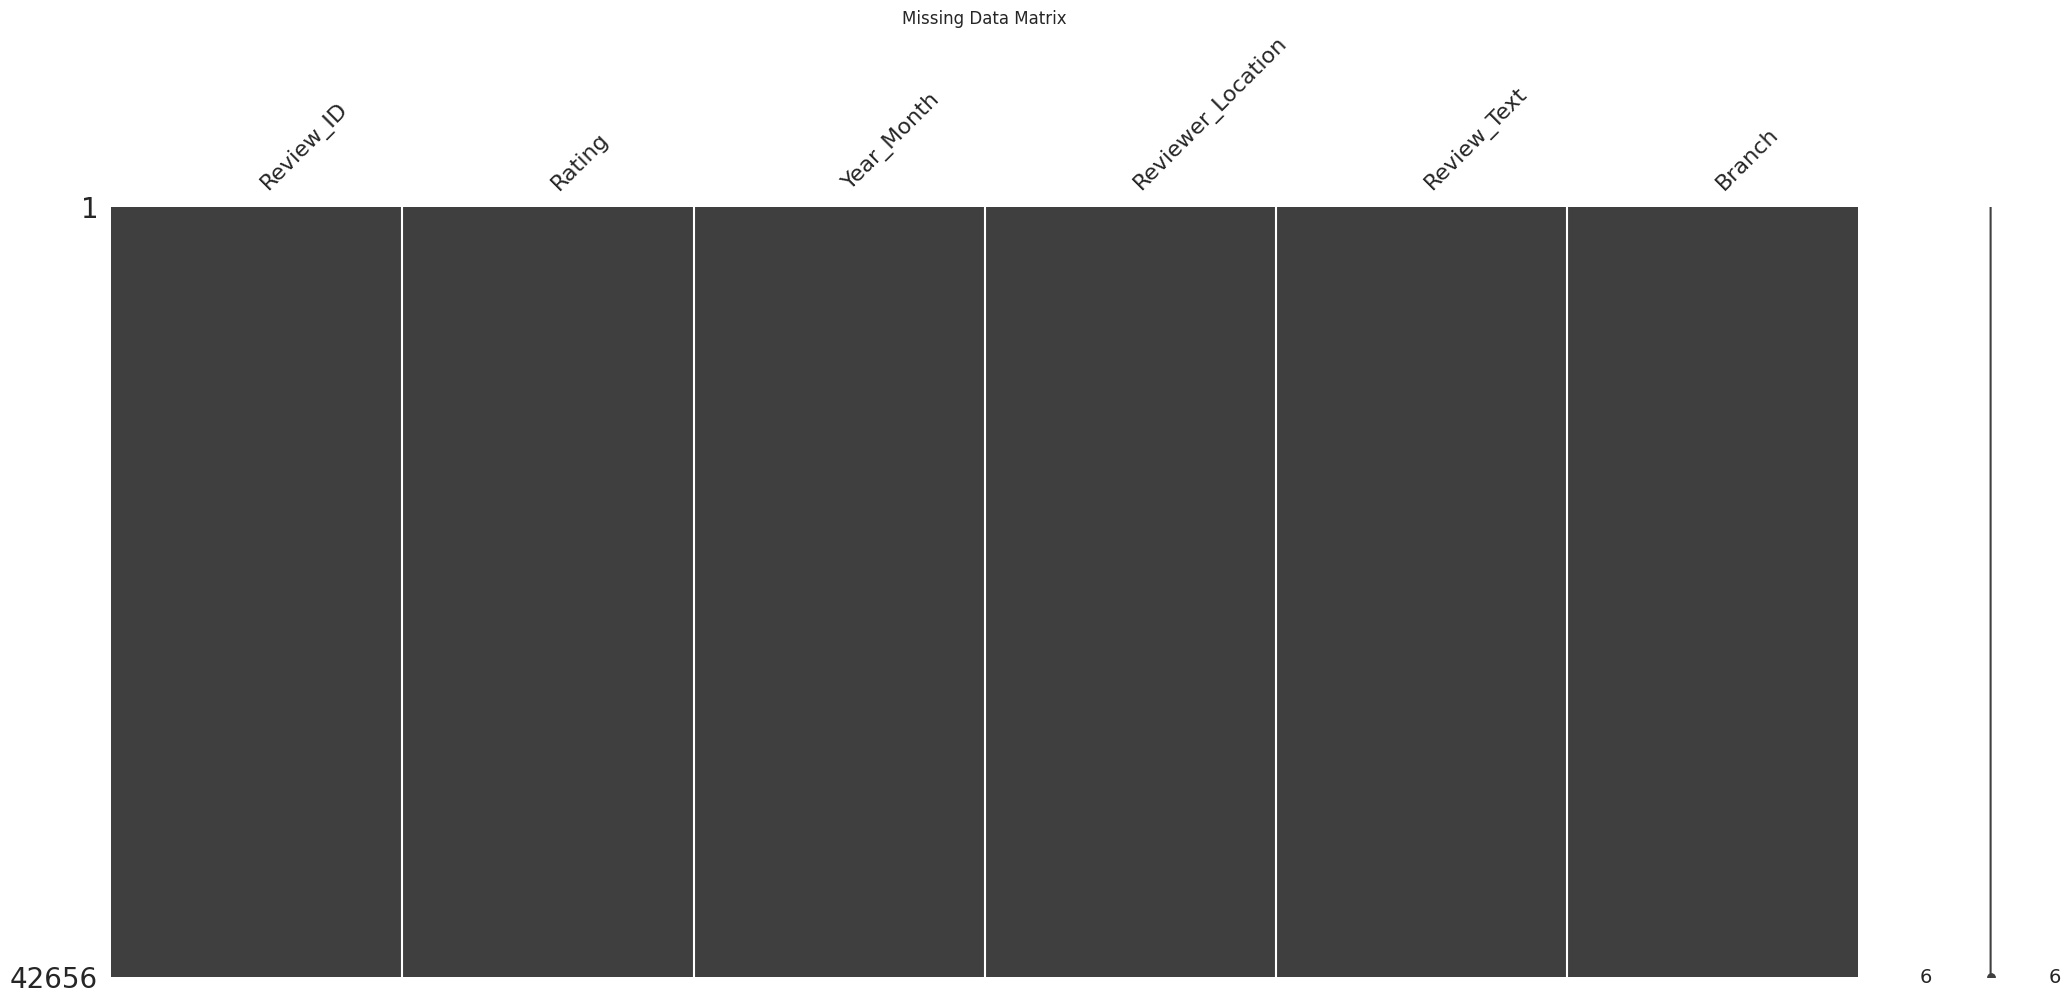

In [116]:
# Visualize the missing value
msno.matrix(disney_df)
plt.title("Missing Data Matrix")
plt.show()

## 3. Data Cleaning

In [120]:
# Removing duplicates from Review column
disney_df.drop_duplicates(subset = ['Review_Text'], inplace = True)

In [121]:
# To check the difference after removing duplicates
print("Shape after removing dupplicates:", disney_df.shape)

Shape after removing dupplicates: (42632, 6)


## 4. Data Summary

In [122]:
# Dataset overview
print(f"Rows       : {disney_df.shape[0]:,}")
print(f"Columns    : {disney_df.shape[1]:,}")
print("\nFeatures   :", disney_df.columns.tolist())

# Missing values
total_missing = disney_df.isnull().sum().sum()
print(f"\nMissing Values : {total_missing:,}")

# Unique values per column
print("\nUnique Values per Column:")
print(disney_df.nunique())

# Value counts for the 'Branch' column
print("\nValue Counts for 'Branch':")
print(disney_df['Branch'].value_counts())

Rows       : 42,632
Columns    : 6

Features   : ['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text', 'Branch']

Missing Values : 0

Unique Values per Column:
Review_ID            42624
Rating                   5
Year_Month             112
Reviewer_Location      162
Review_Text          42632
Branch                   3
dtype: int64

Value Counts for 'Branch':
Branch
Disneyland_California    19399
Disneyland_Paris         13627
Disneyland_HongKong       9606
Name: count, dtype: int64


## 5. Data Preprocessing

In [123]:
# Convert 'Year_Month' assuming format like 'Apr-19' means April 2019
# Standardize column names
disney_df.columns = [col.replace('.', '_') for col in disney_df.columns]

# Convert Year_Month with mixed format handling
def convert_year_month(date_str):
    try:
        # Try format like "Apr-19"
        return pd.to_datetime(date_str, format='%b-%y')
    except ValueError:
        try:
            # Try format like "2019-4"
            return pd.to_datetime(date_str, format='%Y-%m')
        except ValueError:
            return pd.NaT

disney_df['Year_Month'] = disney_df['Year_Month'].apply(convert_year_month)

# Remove rows with invalid dates
initial_count = len(disney_df)
disney_df = disney_df.dropna(subset=['Year_Month'])
cleaned_count = len(disney_df)
print(f"Removed {initial_count - cleaned_count} rows with invalid dates")

Removed 2610 rows with invalid dates


In [124]:
# Extract year, month & day for temporal analysis in EDA
disney_df['Year'] = pd.to_datetime(disney_df['Year_Month']).dt.year
disney_df['Month'] = pd.to_datetime(disney_df['Year_Month']).dt.month

# Remove the 'Year_Month' column
disney_df.drop(columns=['Year_Month'], inplace=True)

# Rearranging the dataset columns
disney_df = disney_df[['Review_ID', 'Rating', 'Year', 'Month', 'Reviewer_Location', 'Review_Text', 'Branch']]

In [125]:
# Verify date column
disney_df.head()

,Review_ID,Rating,Year,Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019,5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [126]:
#Calculating the two lexicon-based sentiment scores
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    tokens = re.findall(r'\b[a-z]{3,}\b', text)
    clean_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]
    return clean_tokens

disney_df['Tokens'] = disney_df['Review_Text'].apply(preprocess)
disney_df['Clean_Text'] = disney_df['Tokens'].apply(lambda x: ' '.join(x))

## 6. Exploratory Data Analysis

### 6.1 Distribution by Rating

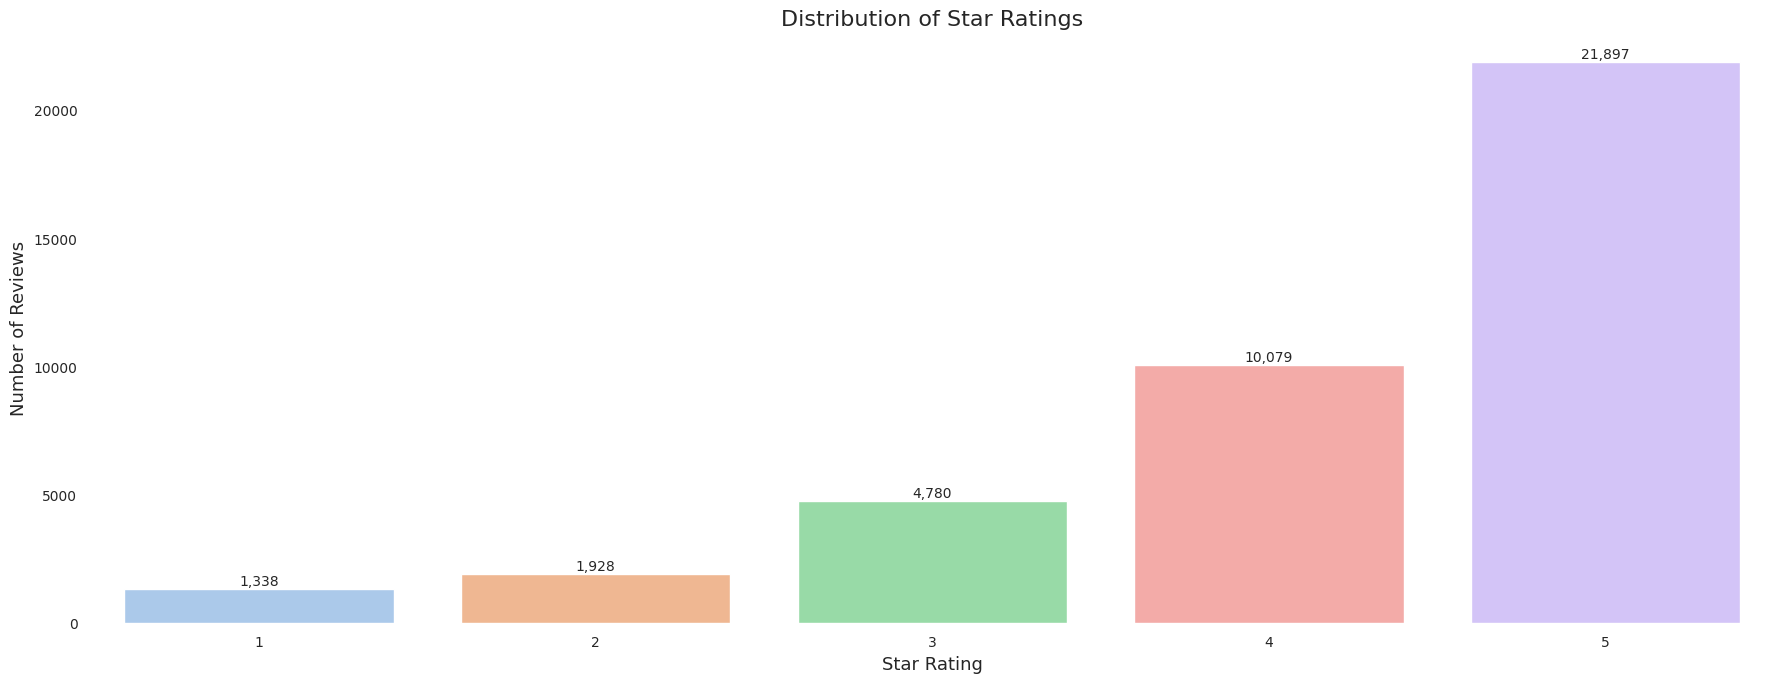

In [127]:
# Custom pastel palette for star rating
sns.set_theme(style='whitegrid')
custom_palette = sns.color_palette("pastel")[:5]

# Set up the figure
plt.figure(figsize=(18, 7))

# Create the countplot
sns.countplot(
    x='Rating',
    data=disney_df,
    hue='Rating',
    palette=custom_palette,
    order=sorted(disney_df['Rating'].unique()),
    legend=False
)

# Get current axis
ax = plt.gca()

# Titles and labels
ax.set_title('Distribution of Star Ratings', fontsize=16)
ax.set_xlabel('Star Rating', fontsize=13)
ax.set_ylabel('Number of Reviews', fontsize=13)
ax.set_facecolor('white')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove outline (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove grid
ax.grid(False)

# Add value labels on top of bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 6.2 Rating Distribution by Park

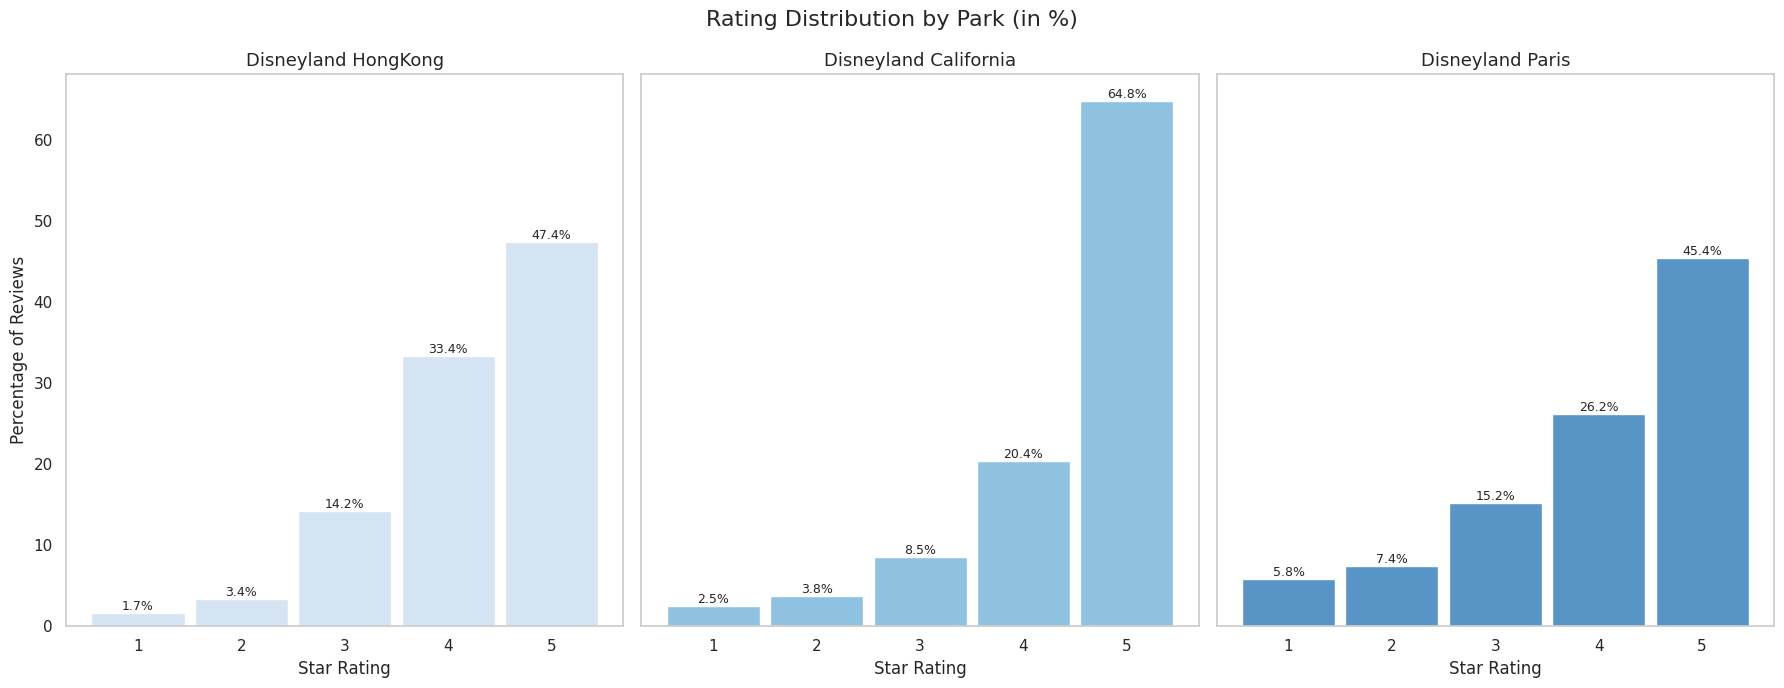

In [128]:
# Set a theme and color palette
sns.set_theme(style='whitegrid')
custom_palette = sns.color_palette('Blues', n_colors=3)

# Prepare unique parks
branch_list = disney_df['Branch'].unique()
n_parks = len(branch_list)

# Set up subplot grid
fig, axes = plt.subplots(1, n_parks, figsize=(18, 7), sharey=True)
axes = axes.flatten()

# Main title
fig.suptitle('Rating Distribution by Park (in %)', fontsize=16)

# Plot each park
for i, branch in enumerate(branch_list):
    ax = axes[i]
    data = disney_df[disney_df['Branch'] == branch]

    # Clean display name
    branch_clean = branch.replace('_', ' ')

    sns.histplot(
        data=data,
        x='Rating',
        stat='percent',
        discrete=True,
        bins=5,
        shrink=0.9,
        color=custom_palette[i],
        ax=ax
    )

    ax.set_title(branch_clean, fontsize=13)
    ax.set_xlabel('Star Rating')
    ax.grid(False)

    if i == 0:
        ax.set_ylabel('Percentage of Reviews')
    else:
        ax.set_ylabel('')

    # Add percentage labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=9)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### 6.3 Reviews by Disneyland Park

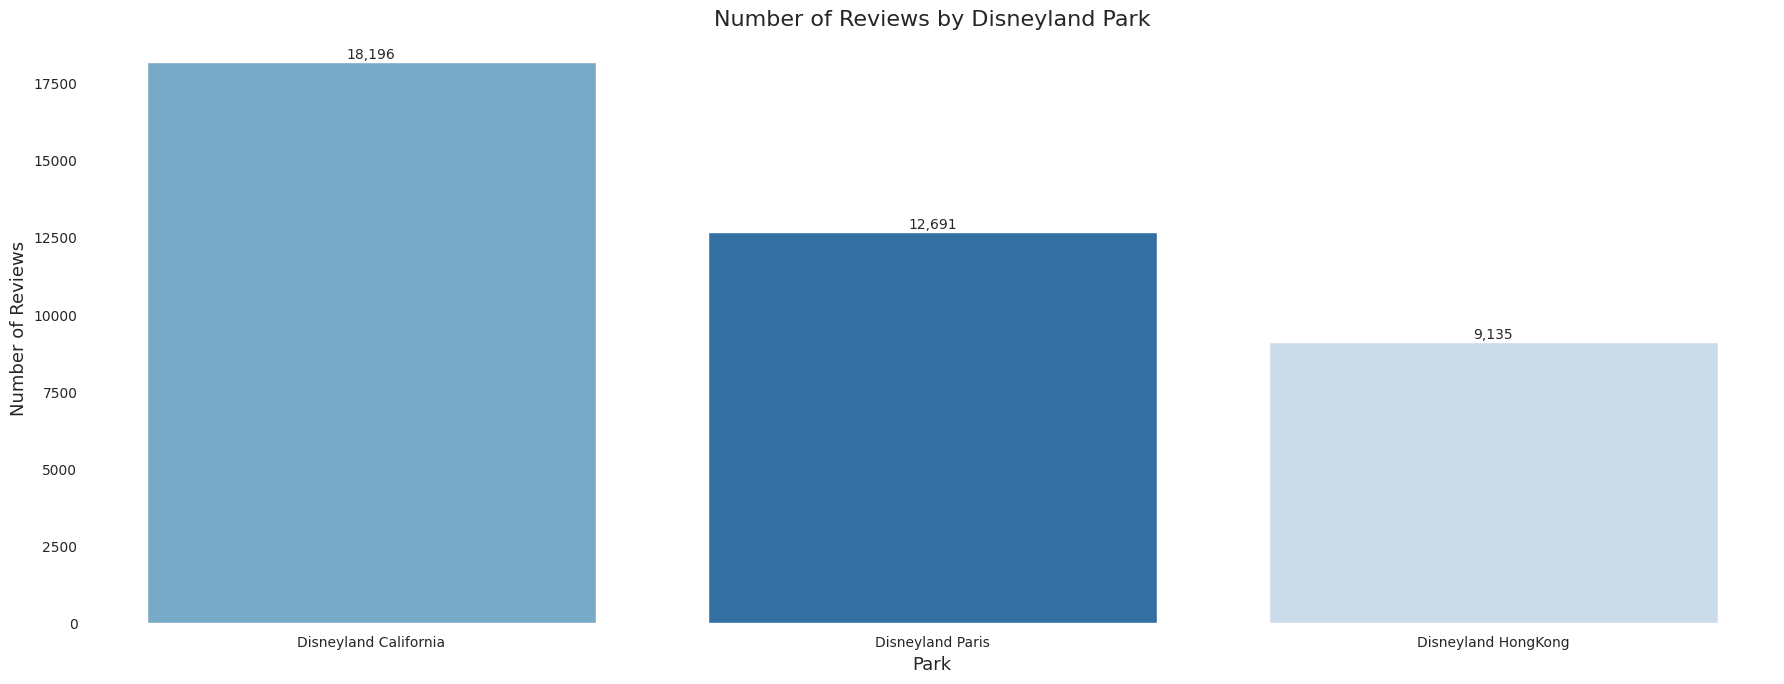

In [129]:
# Set Seaborn style
sns.set_style("whitegrid")
custom_palette = sns.color_palette('Blues', n_colors=3)

# Get ordered branch names and cleaned labels
branch_order = disney_df['Branch'].value_counts().index
branch_labels = [branch.replace('_', ' ') for branch in branch_order]

# Plot
plt.figure(figsize=(18, 7))
ax = sns.countplot(
    x='Branch',
    data=disney_df,
    order=branch_order,
    hue='Branch',
    palette=custom_palette,
    legend=False
)

# x-axis ticks with readable labels
ax.set_xticks(range(len(branch_order)))
ax.set_xticklabels(branch_labels, rotation=0)

# Titles and labels
ax.set_title('Number of Reviews by Disneyland Park', fontsize=16)
ax.set_xlabel('Park', fontsize=13)
ax.set_ylabel('Number of Reviews', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove outline borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Add count labels above bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.grid(False)
plt.show()

### 6.4 Reviews Over Time (Year & Month)

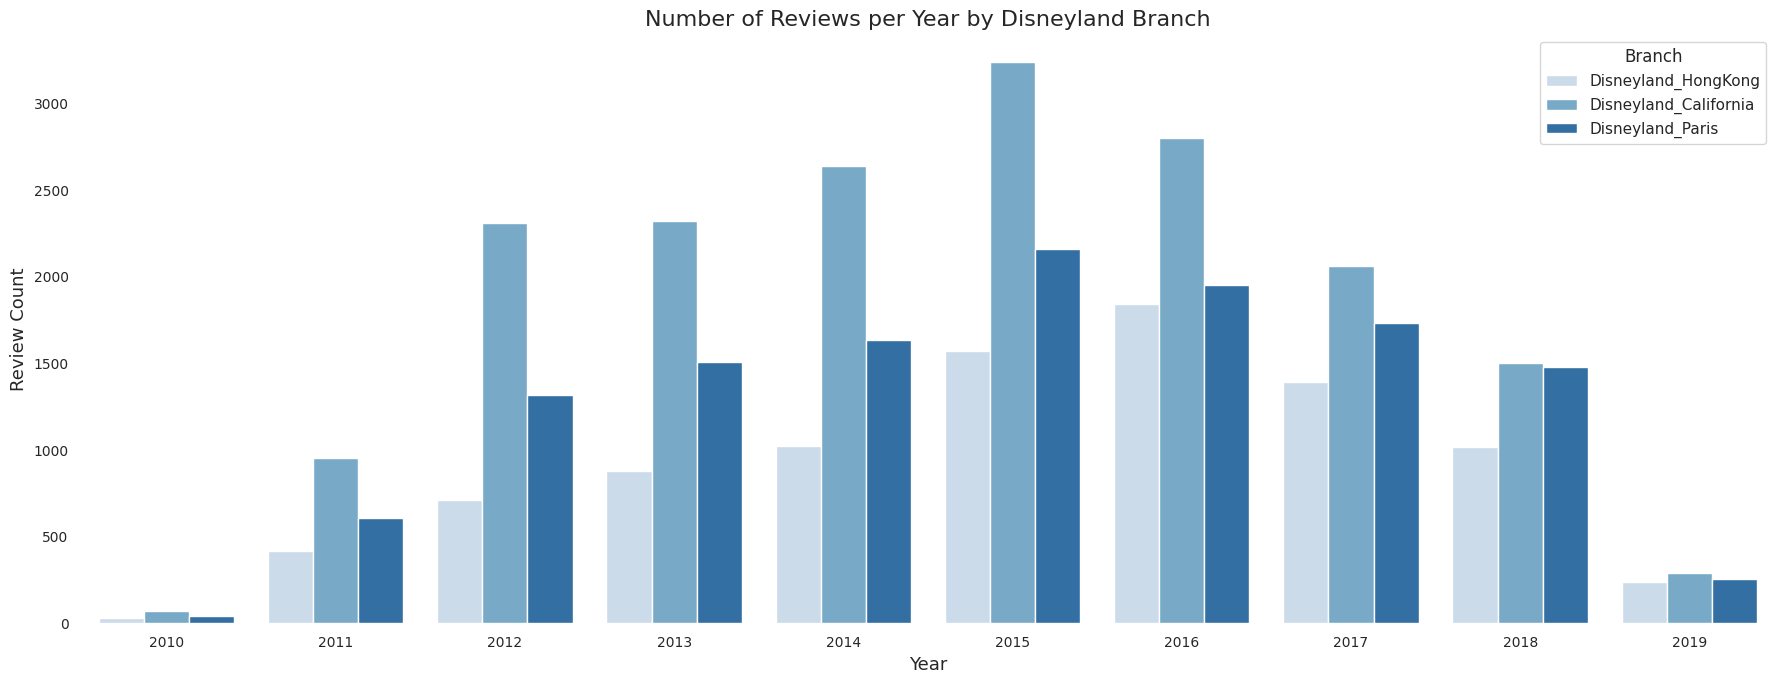

In [130]:
# Set style
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(18, 7))
ax = sns.countplot(
    x='Year',
    hue='Branch',
    data=disney_df,
    order=sorted(disney_df['Year'].dropna().unique()),
    palette='Blues'
)

# Titles and axis labels
ax.set_title('Number of Reviews per Year by Disneyland Branch', fontsize=16)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Review Count', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove all spines for clean look
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.grid(False)
plt.legend(title='Branch')
plt.show()

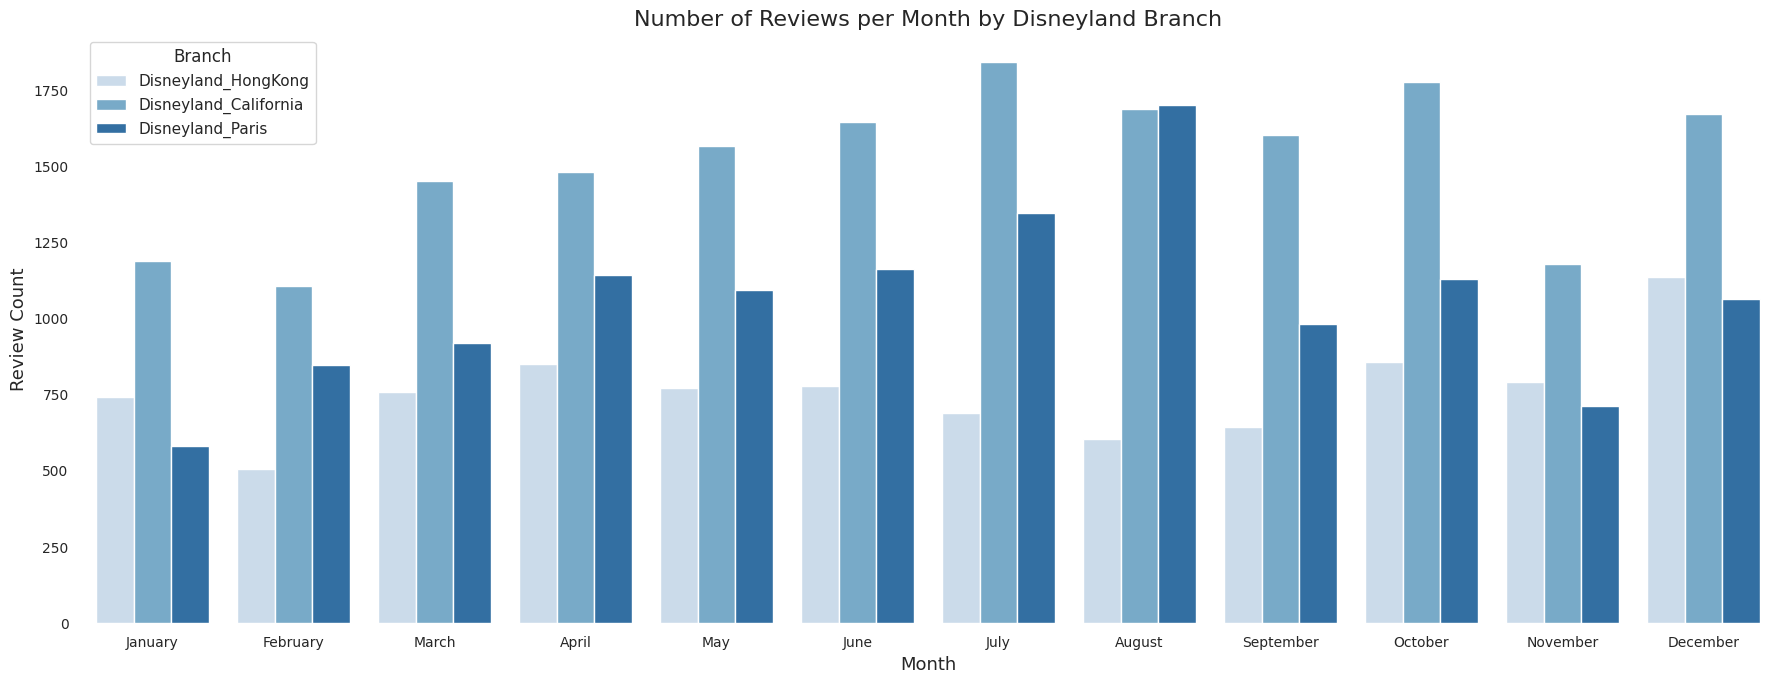

In [131]:
# Map numeric month to month name
disney_df['Month_Name'] = disney_df['Month'].apply(lambda x: calendar.month_name[int(x)] if pd.notnull(x) else x)

# Define ordered categorical for plotting
month_order = list(calendar.month_name)[1:]
disney_df['Month_Name'] = pd.Categorical(disney_df['Month_Name'], categories=month_order, ordered=True)

# Plot
plt.figure(figsize=(18, 7))
ax = sns.countplot(
    x='Month_Name',
    hue='Branch',
    data=disney_df,
    order=month_order,
    palette='Blues'
)

# Titles and labels
ax.set_title('Number of Reviews per Month by Disneyland Branch', fontsize=16)
ax.set_xlabel('Month', fontsize=13)
ax.set_ylabel('Review Count', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)


# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.grid(False)
plt.legend(title='Branch')
plt.show()

### 6.5 Top 15 Reviewer Locations

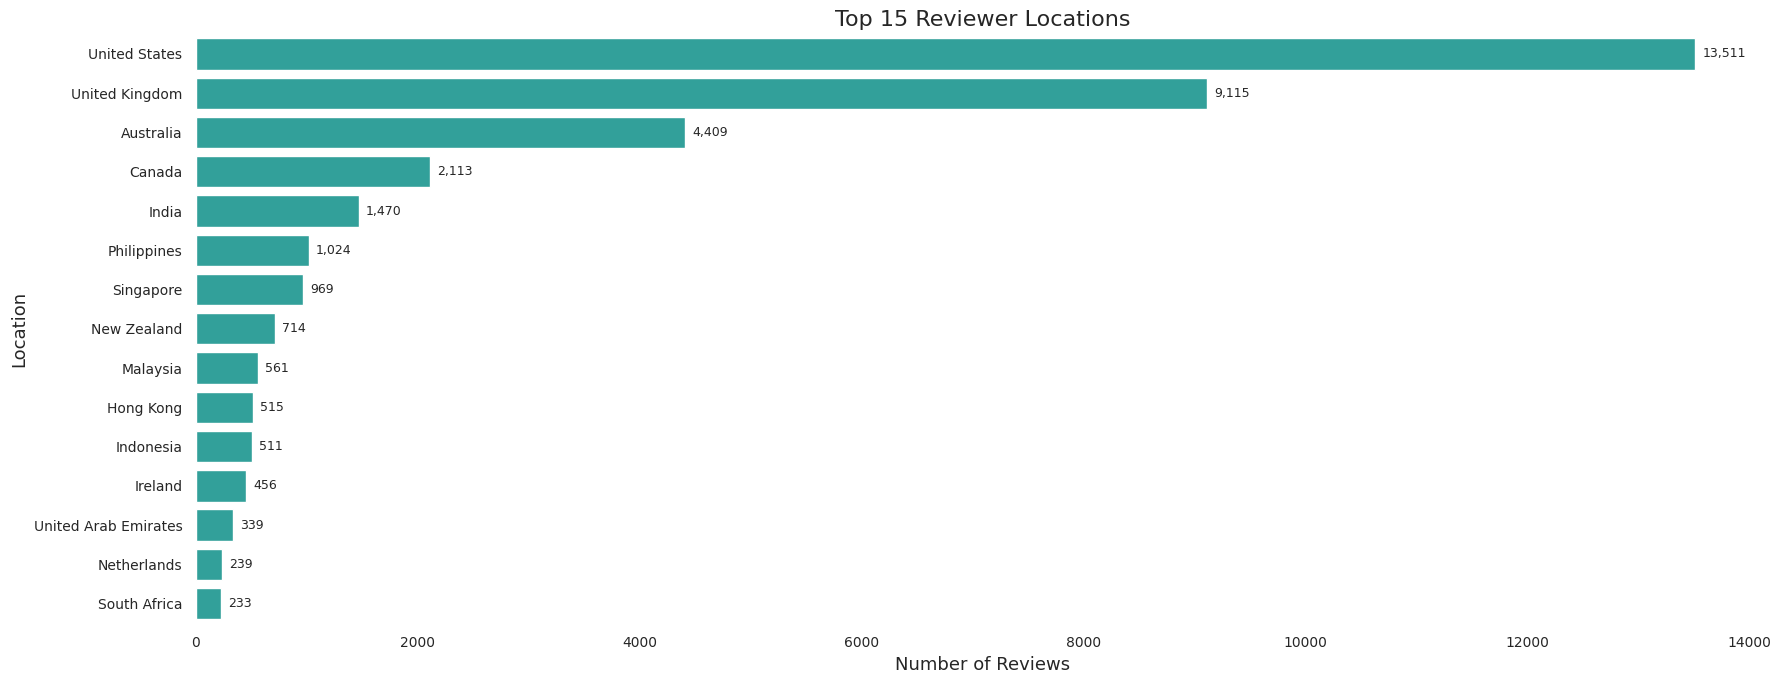

In [132]:
# Extract top 15 reviewer locations by count
top_locations = disney_df['Reviewer_Location'].value_counts().head(15)

plt.figure(figsize=(18, 7))
ax = sns.barplot(
    x=top_locations.values,
    y=top_locations.index,
    color='#20B2AA'
)

# Add titles and labels with larger font
ax.set_title('Top 15 Reviewer Locations', fontsize=16)
ax.set_xlabel('Number of Reviews', fontsize=13)
ax.set_ylabel('Location', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Add count labels on bars
for bar in ax.patches:
    width = int(bar.get_width())
    ax.annotate(f'{width:,}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0),
                textcoords='offset points',
                ha='left', va='center',
                fontsize=9)

plt.tight_layout()
plt.grid(False)
plt.show()

### 6.6 Review Length

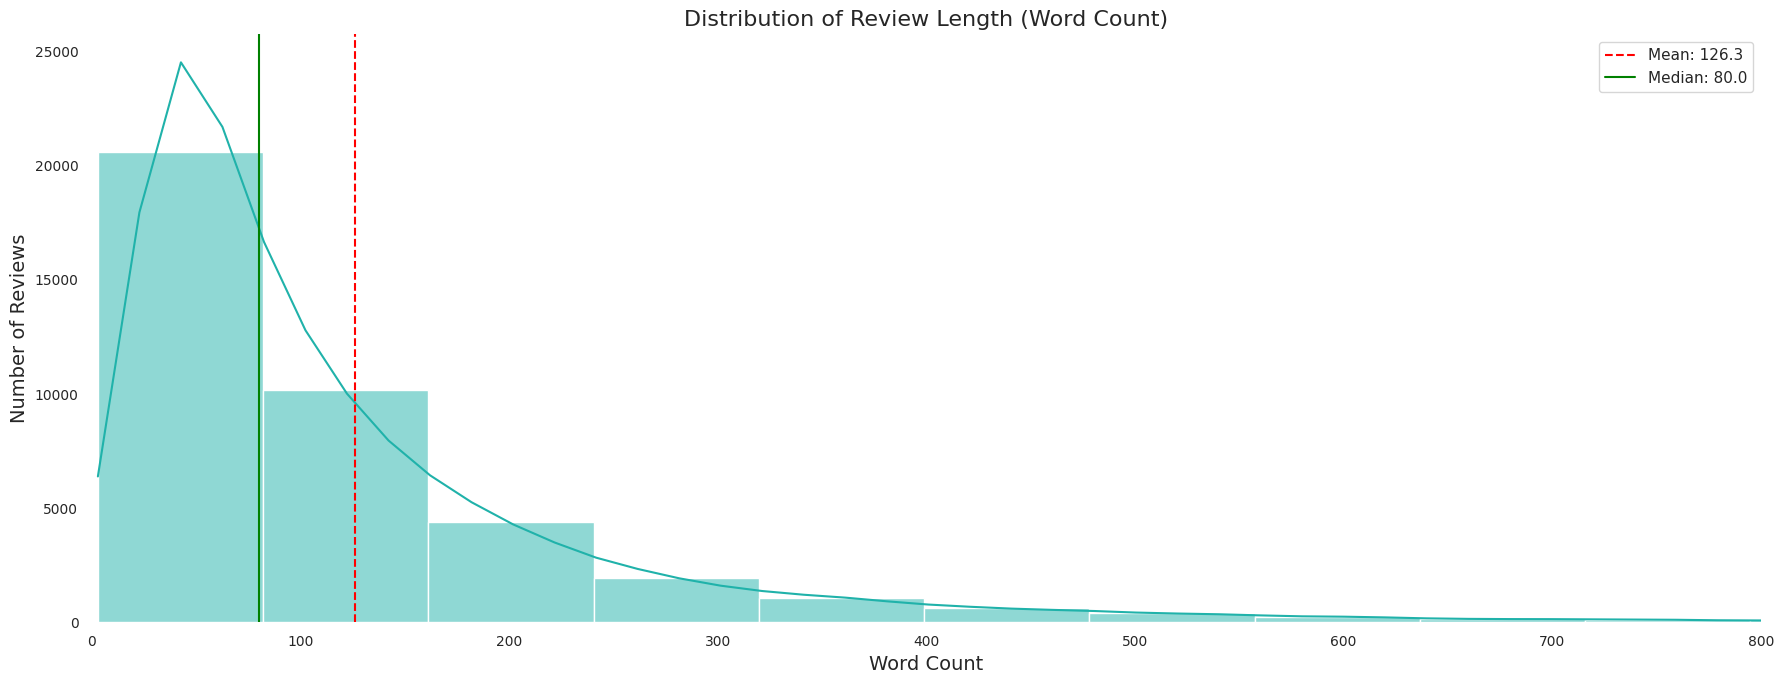

In [133]:
# Calculate review length in words
disney_df['review_length'] = disney_df['Review_Text'].str.split().apply(len)

# Basic stats
mean_len = disney_df['review_length'].mean()
median_len = disney_df['review_length'].median()

# Set plot size
plt.figure(figsize=(18, 7))

# Plot
sns.histplot(disney_df['review_length'], bins=50, kde=True, color='#20B2AA')

# Titles and styles
plt.title('Distribution of Review Length (Word Count)', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

# Add vertical lines for mean and median
plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
plt.axvline(median_len, color='green', linestyle='-', label=f'Median: {median_len:.1f}')
plt.legend()

# Remove chart borders/spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Optional: remove grid lines
plt.grid(False)

# Limit x-axis
plt.xlim(0, 800)

plt.tight_layout()
plt.show()

### 6.7 Rating per Year

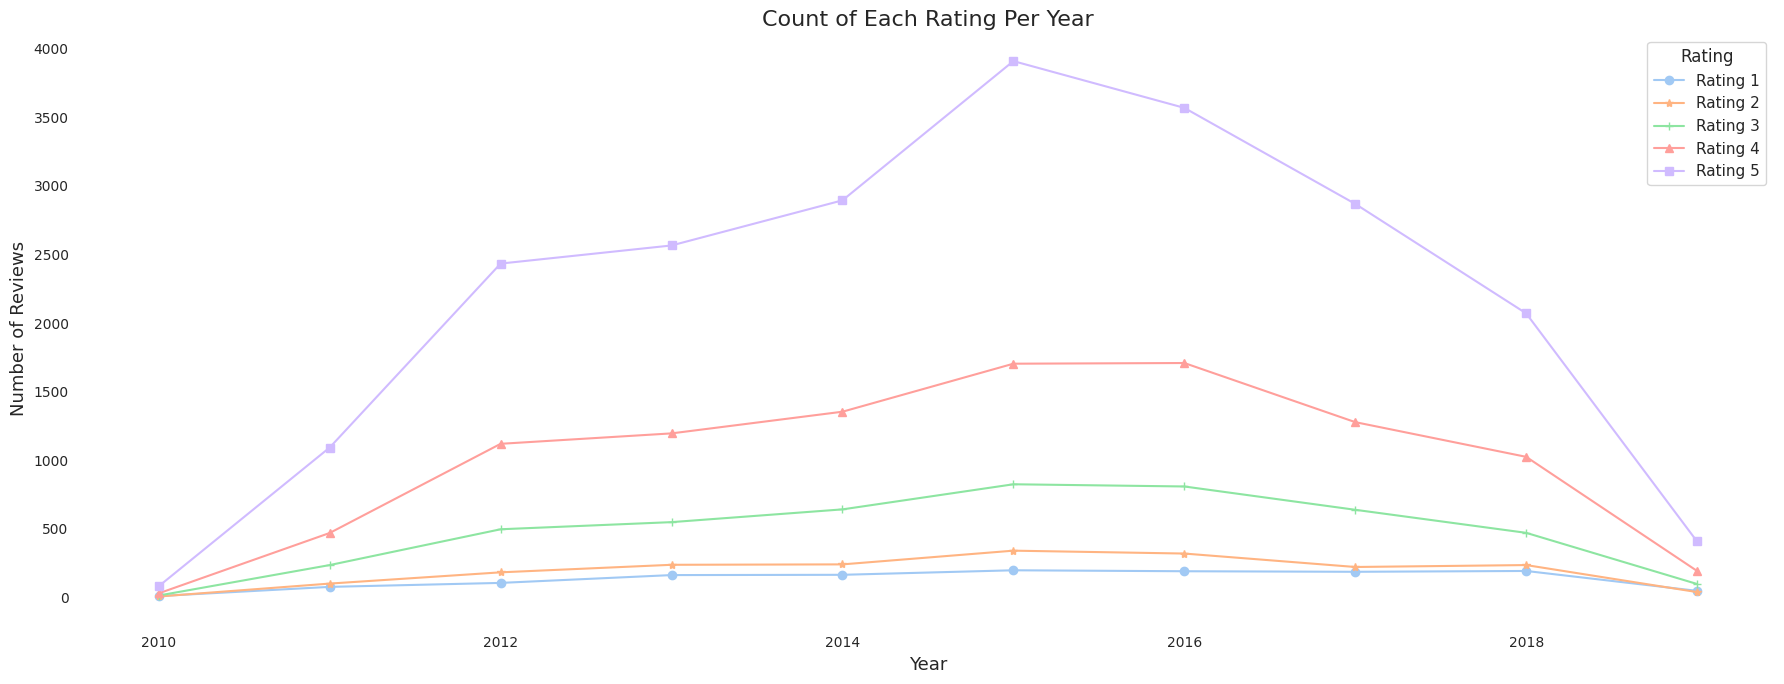

In [134]:
# Count how many times each rating appears per year
rating_counts = (
    disney_df.groupby(['Year', 'Rating'])
    .size()
    .reset_index(name='Count')
)

# Pivot for plotting
rating_pivot = rating_counts.pivot(index='Year', columns='Rating', values='Count').fillna(0)

# Custom pastel palette (exactly 5 colors for 5 ratings)
custom_palette = sns.color_palette("pastel")[:5]

# Plot
plt.figure(figsize=(18, 7))
sns.set_style("white")

markers = ['o', '*', '+', '^', 's']

for i, rating in enumerate(sorted(rating_pivot.columns)):
    plt.plot(
        rating_pivot.index,
        rating_pivot[rating],
        marker=markers[i % len(markers)],
        color=custom_palette[i % len(custom_palette)],
        label=f'Rating {int(rating)}'
    )

# Titles and labels
plt.title('Count of Each Rating Per Year', fontsize=16)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Reviews', fontsize=13)
plt.legend(title='Rating')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.xticks(rotation=0)

# Remove all borders/spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# No grid
plt.grid(False)

plt.tight_layout()
plt.show()

### 6.8 Review Count & Average Rating by Country

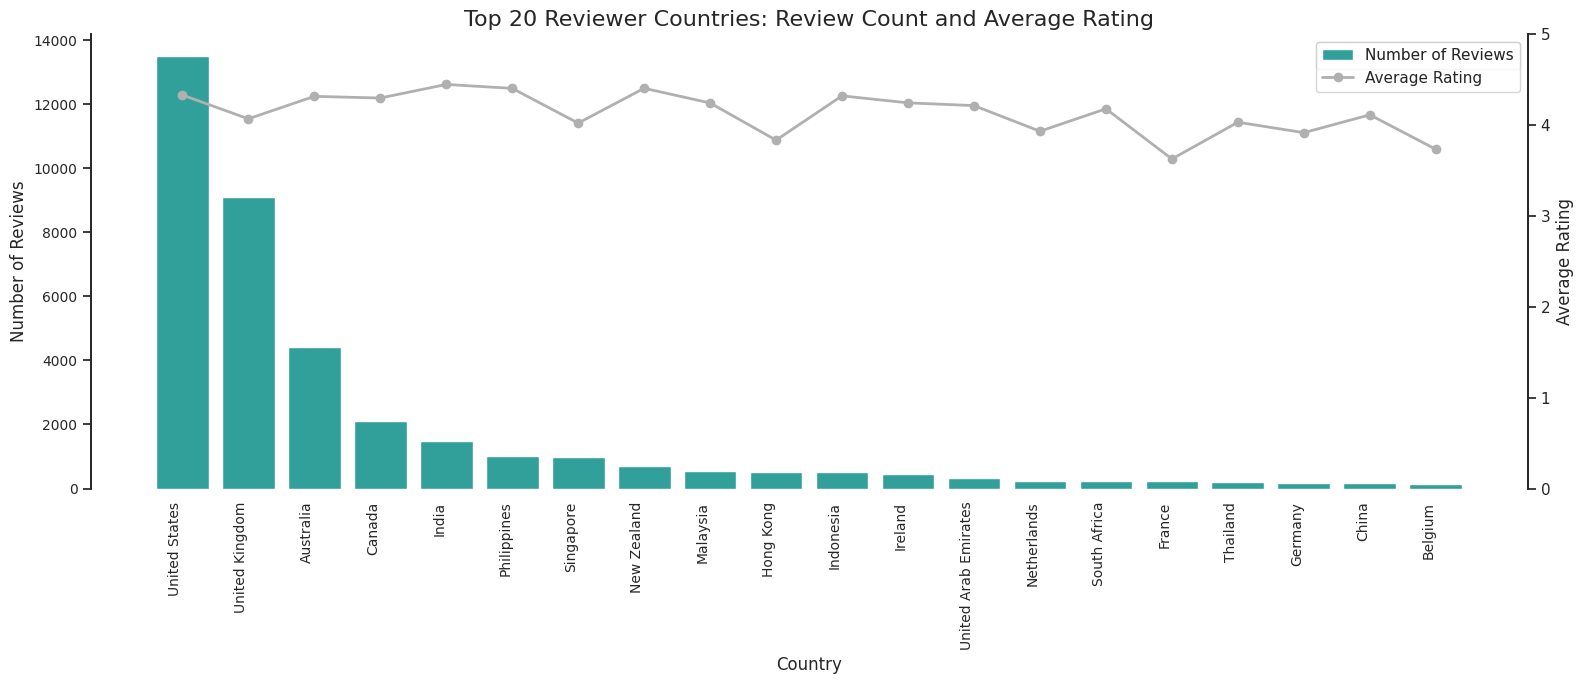

In [135]:
# Group by Reviewer_Location
location_stats = (
    disney_df.groupby('Reviewer_Location')
    .agg(Review_Count=('Rating', 'count'), Avg_Rating=('Rating', 'mean'))
    .sort_values('Review_Count', ascending=False)
    .head(20)
    .reset_index()
)

# Sort by Review_Count for better visual order
location_stats = location_stats.sort_values('Review_Count', ascending=False)

# Plot
plt.figure(figsize=(16, 7))
sns.set_style("white")

# Bar chart for number of reviews
ax = sns.barplot(
    data=location_stats,
    x='Reviewer_Location',
    y='Review_Count',
    color='#20B2AA',
    label='Number of Reviews'
)

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

# Create second y-axis for average rating
ax2 = ax.twinx()

# Line plot for average rating
ax2.plot(
    location_stats['Reviewer_Location'],
    location_stats['Avg_Rating'],
    color='#B0B0B0',
    marker='o',
    label='Average Rating',
    linewidth=2
)

# Customize axes
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax2.set_ylabel('Average Rating', fontsize=12)
ax.set_title('Top 20 Reviewer Countries: Review Count and Average Rating', fontsize=16)

# Format ticks
ax.set_xticklabels(location_stats['Reviewer_Location'], rotation=90, ha='right')
ax2.set_ylim(0, 5)

# Add legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Remove top and right spines
sns.despine(top=True, right=False, left=False, bottom=True)

# No grid
plt.grid(False)

plt.tight_layout()
plt.show()

## 7. Sentiment Analysis

### 7.1 Text Preprocessing

In [136]:
# Preview
disney_df[['Review_Text', 'Tokens']].head()

,Review_Text,Tokens
0,If you've ever been to Disneyland anywhere you...,"[ever, disneyland, anywhere, find, disneyland,..."
1,Its been a while since d last time we visit HK...,"[since, last, time, visit, disneyland, yet, ti..."
2,Thanks God it wasn t too hot or too humid wh...,"[thanks, god, hot, humid, visiting, park, othe..."
3,HK Disneyland is a great compact park. Unfortu...,"[disneyland, great, compact, park, unfortunate..."
4,"the location is not in the city, took around 1...","[location, city, took, around, hour, kowlon, k..."


### 7.2 Sentiment Analysis (Lexicon-Based)

In [137]:
# Initialize only once
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0  # Neutral for empty or invalid input
    score = sia.polarity_scores(text).get('compound', 0.0)
    return round(score, 4)  # Rounded for better readability

# Apply sentiment analysis
disney_df['Sentiment_Score'] = disney_df['Review_Text'].apply(get_sentiment)

# Preview
disney_df[['Review_Text', 'Sentiment_Score']].head()

,Review_Text,Sentiment_Score
0,If you've ever been to Disneyland anywhere you...,0.7069
1,Its been a while since d last time we visit HK...,0.9901
2,Thanks God it wasn t too hot or too humid wh...,0.9920
3,HK Disneyland is a great compact park. Unfortu...,0.8489
4,"the location is not in the city, took around 1...",0.2846


### 7.3 Compare Rating vs Sentiment Score

In [138]:
#Lexicon-Based Sentiment
import urllib.request

def load_lexicon(url):
    lexicon = {}
    response = urllib.request.urlopen(url)
    for line in response:
        word, score = line.decode('utf-8').strip().split('\t')
        lexicon[word] = float(score)
    return lexicon

#URL
lexicon_url = "https://raw.githubusercontent.com/wd13ca/BAN200-Summer-2025/main/lexicon.txt"
lexicon = load_lexicon(lexicon_url)

def vectorize_tf(tokens):
    tf = {}
    for t in tokens:
        tf[t] = tf.get(t, 0) + 1
    return tf

# Calculate TF-IDF weights
N = len(disney_df)
doc_freq = {}
for tokens in disney_df['Tokens']:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        doc_freq[token] = doc_freq.get(token, 0) + 1

idf_dict = {token: log(N / (df_count + 1)) for token, df_count in doc_freq.items()}

def vectorize_tf_idf(tokens):
    tf = vectorize_tf(tokens)
    tf_idf = {}
    for token, freq in tf.items():
        if token in idf_dict:
            tf_idf[token] = freq * idf_dict[token]
    return tf_idf

disney_df['tf_idf'] = disney_df['Tokens'].apply(vectorize_tf_idf)

# Sentiment scoring functions
def sparse_dot_product(vec1, vec2):
    return sum(vec1.get(t, 0) * vec2.get(t, 0) for t in set(vec1) | set(vec2))

disney_df['Lexicon_Score'] = disney_df['tf_idf'].apply(
    lambda x: sparse_dot_product(x, lexicon)
)

# Correlation analysis
corr_tfidf = disney_df['Rating'].corr(disney_df['Lexicon_Score'])
print(f"Correlation between Rating and Lexicon TF-IDF: {corr_tfidf:.3f}")

Correlation between Rating and Lexicon TF-IDF: 0.273


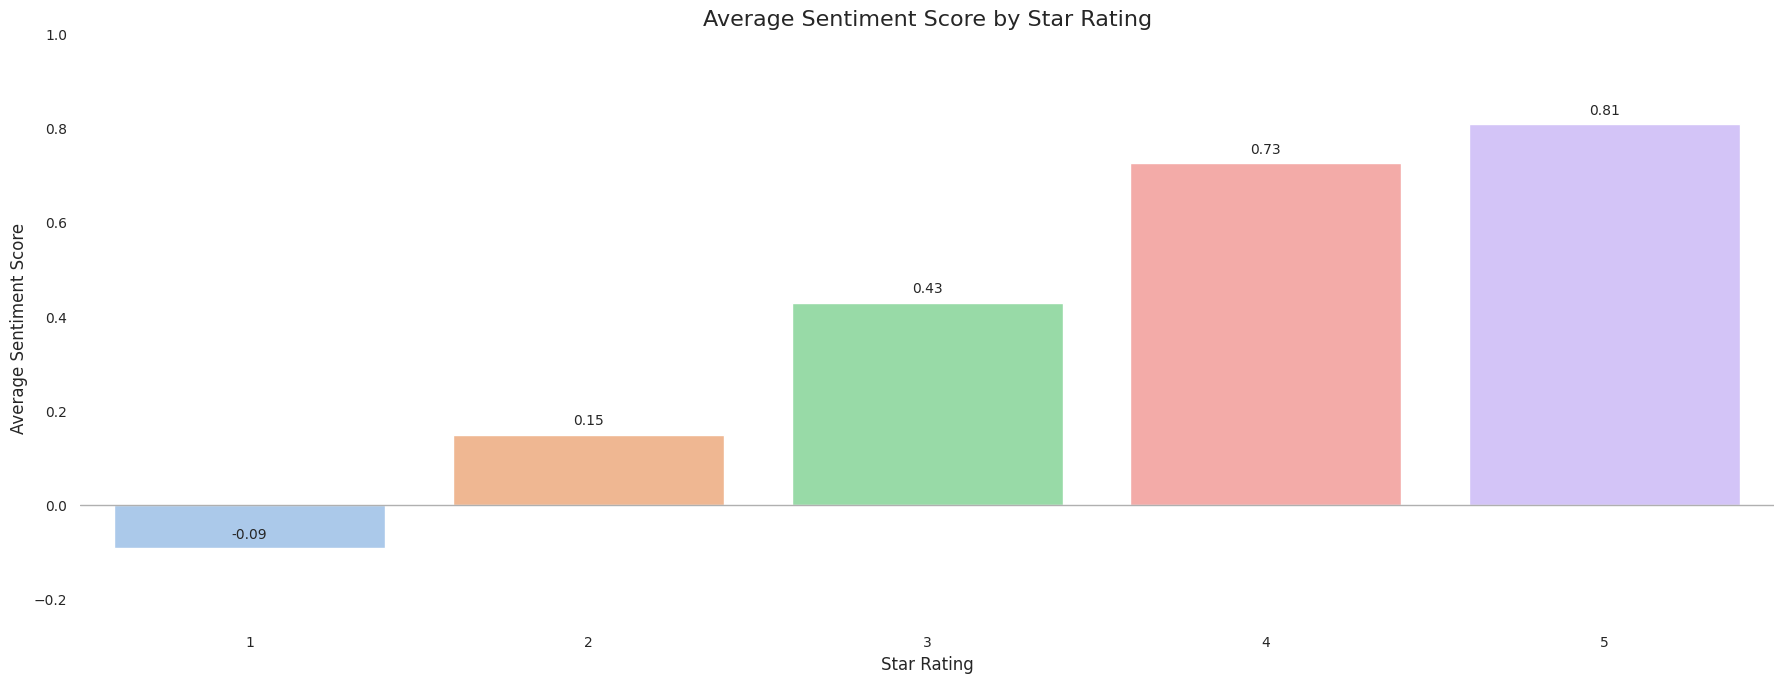

In [139]:
# Group by Rating and calculate average sentiment score
avg_sentiment_by_rating = disney_df.groupby('Rating')['Sentiment_Score'].mean().reset_index()

# Plotting
plt.figure(figsize=(18, 7))
sns.barplot(data=avg_sentiment_by_rating, x='Rating', y='Sentiment_Score', palette='pastel')

# Styling
plt.title('Average Sentiment Score by Star Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(-0.25, 1)  # sentiment score range

# Add score labels on bars
for index, row in avg_sentiment_by_rating.iterrows():
    plt.text(row['Rating'] - 1, row['Sentiment_Score'] + 0.02, f"{row['Sentiment_Score']:.2f}",
             ha='center', fontsize=10)

# Add a horizontal line at y=0
plt.axhline(y=0, color='#B0B0B0', linewidth=1)

# Remove grid
plt.grid(False)

# Remove all borders/spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Final layout
plt.tight_layout()
plt.show()


### 7.4 TF-IDF + N-Gram Analysis

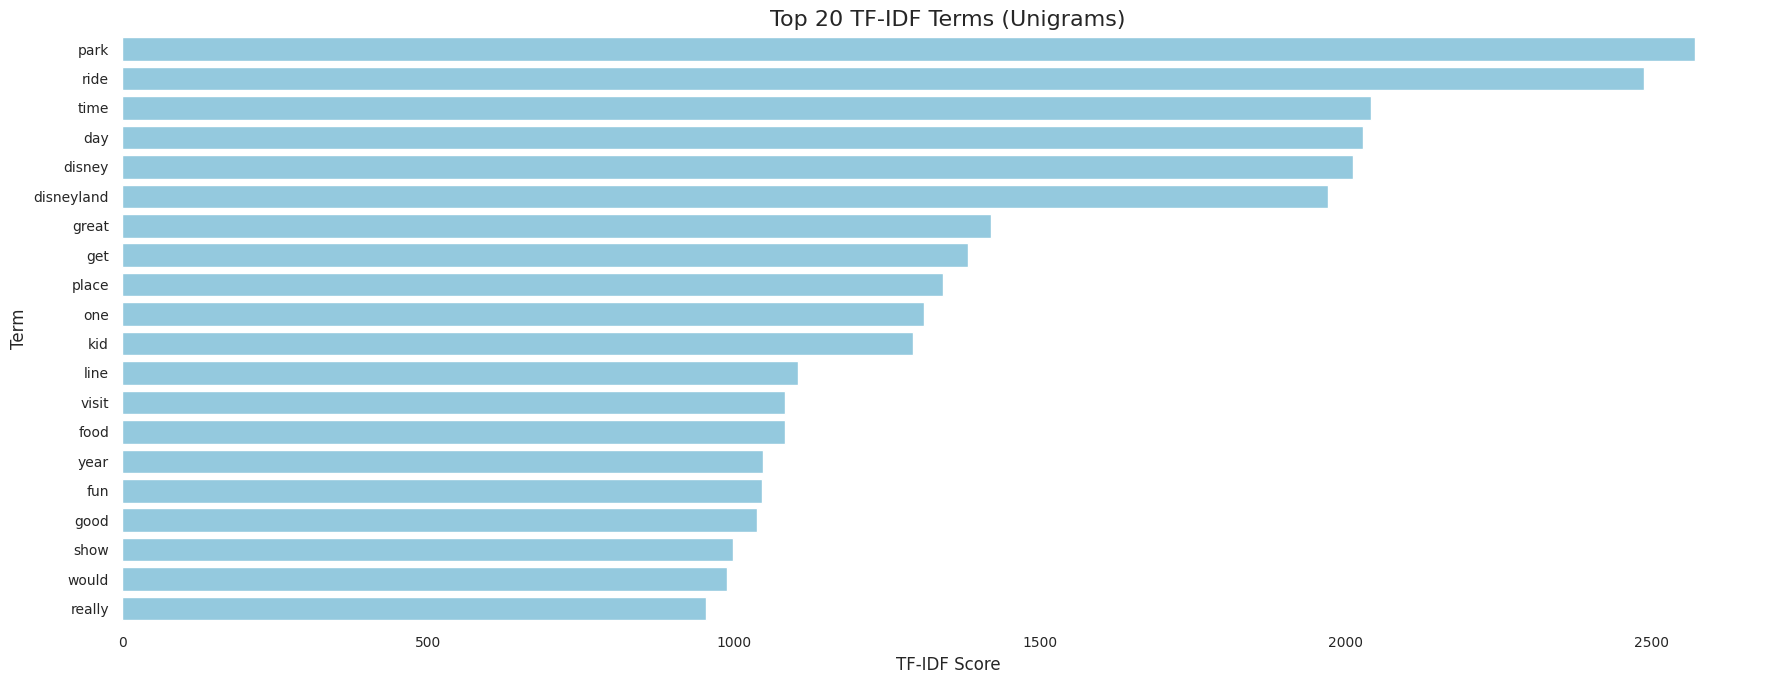

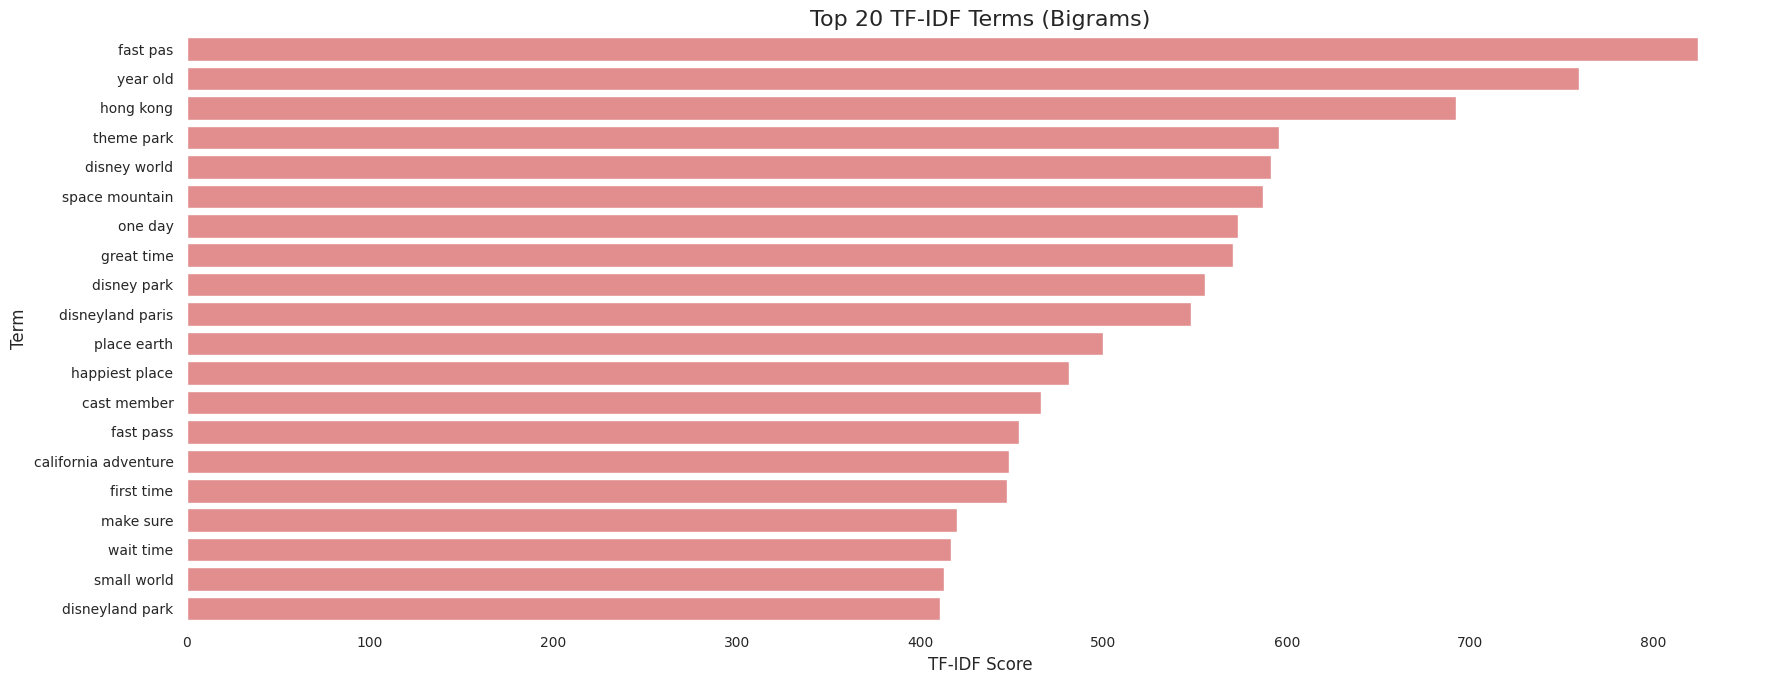

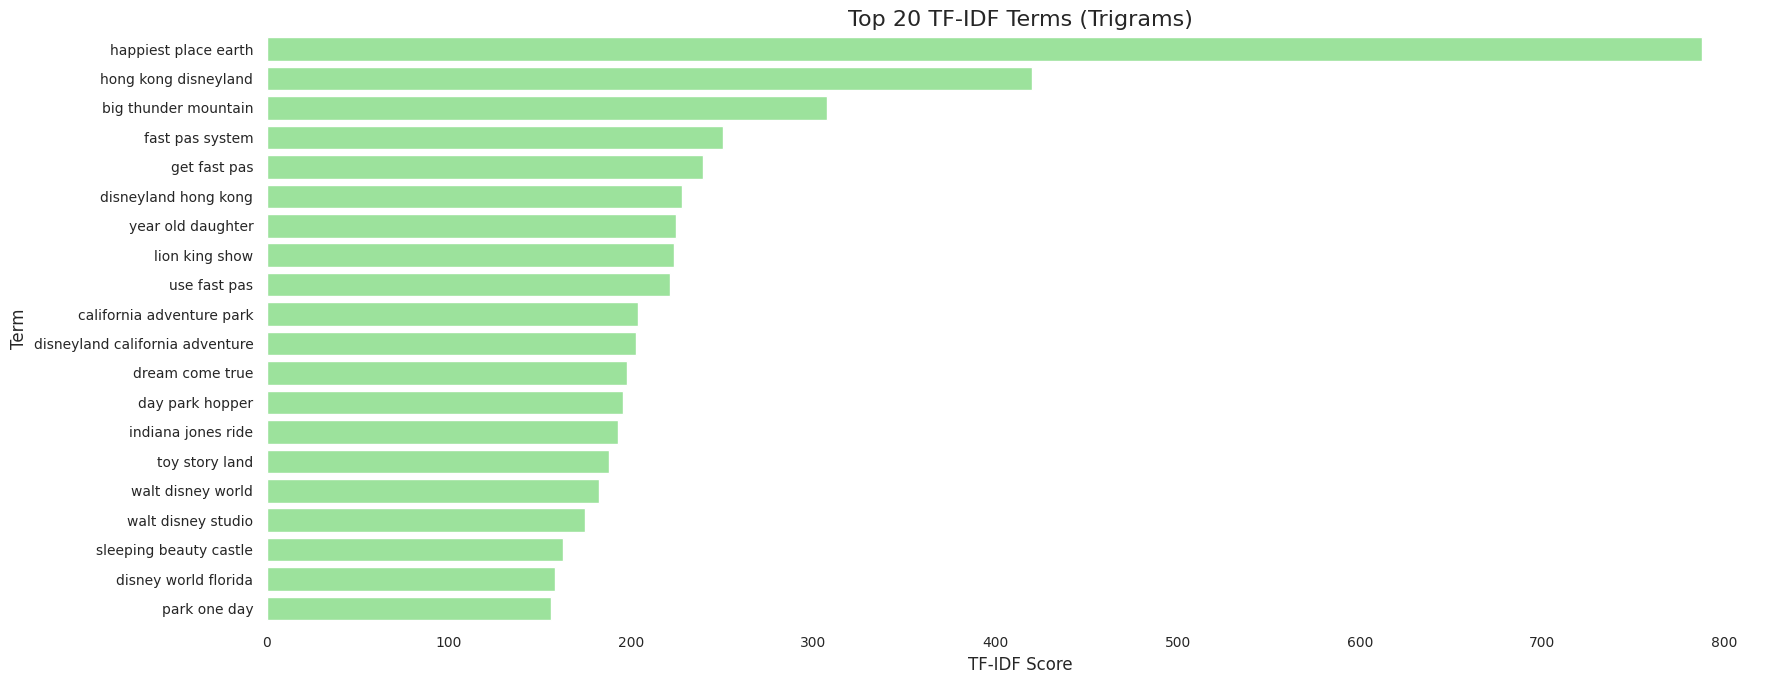

In [140]:
# Ensure Clean_Text column is ready
disney_df['Clean_Text'] = disney_df['Tokens'].apply(lambda tokens: ' '.join(tokens))

# Define n-gram settings
ngram_ranges = [(1, 1), (2, 2), (3, 3)]
titles = ['Unigrams', 'Bigrams', 'Trigrams']
bar_colors = ['skyblue', 'lightcoral', 'lightgreen']

# Loop through n-grams
for ngram, title, color in zip(ngram_ranges, titles, bar_colors):
    vectorizer = TfidfVectorizer(ngram_range=ngram, max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(disney_df['Clean_Text'])

    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()

    top_indices = tfidf_scores.argsort()[::-1][:20]
    top_terms = [(terms[i], tfidf_scores[i]) for i in top_indices]
    words, scores = zip(*top_terms)

    # Plot
    plt.figure(figsize=(18, 7))
    sns.barplot(x=scores, y=words, color=color)

    plt.title(f'Top 20 TF-IDF Terms ({title})', fontsize=16)
    plt.xlabel('TF-IDF Score', fontsize=12)
    plt.ylabel('Term', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Remove grid and all spines
    plt.grid(False)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()

    # Force extra blank space between plots
    print("\n" * 2)


### 7.5 LDA Topic Modelling

In [141]:
# Create combined stopwords
custom_stopwords = set(['disneyland', 'california', 'paris', 'disney', 'hong', 'kong'])
combined_stopwords = ENGLISH_STOP_WORDS.union(stopwords.words('english')).union(custom_stopwords)

# Sentiment labeling and filtering
disney_df['Sentiment_Label'] = disney_df['Sentiment_Score'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)
disney_df = disney_df[disney_df['Sentiment_Label'] != 'Neutral']

positive_reviews = disney_df[disney_df['Sentiment_Label'] == 'Positive']
negative_reviews = disney_df[disney_df['Sentiment_Label'] == 'Negative']

# Define lda_topics function to create vectorizer, fit_transform, lda, and return feature names
def lda_topics(text_series, n_topics=4):
    vectorizer = CountVectorizer(
        stop_words=list(combined_stopwords),
        ngram_range=(2, 2),  # bigrams only
        max_df=0.8,
        min_df=5
    )
    dtm = vectorizer.fit_transform(text_series)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=26)
    lda.fit(dtm)
    feature_names = vectorizer.get_feature_names_out()
    return lda, dtm, feature_names

lda_pos, dtm_pos, feat_names_pos = lda_topics(positive_reviews['Clean_Text'], n_topics=4)
lda_neg, dtm_neg, feat_names_neg = lda_topics(negative_reviews['Clean_Text'], n_topics=4)

# Function to get dominant topic per document
def get_dominant_topic(lda_model, dtm):
    topic_distributions = lda_model.transform(dtm)
    dominant_topics = topic_distributions.argmax(axis=1)
    return dominant_topics

positive_reviews = positive_reviews.copy()
negative_reviews = negative_reviews.copy()

positive_reviews['Dominant_Topic_Pos'] = get_dominant_topic(lda_pos, dtm_pos)
negative_reviews['Dominant_Topic_Neg'] = get_dominant_topic(lda_neg, dtm_neg)

# Function to display top words per topic
def display_top_words(lda_model, feature_names, n_top_words=10):
    topics_words = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

positive_top_words = display_top_words(lda_pos, feat_names_pos)
negative_top_words = display_top_words(lda_neg, feat_names_neg)

# Display themes
print("Positive Review Themes:\n")
for i, words in enumerate(positive_top_words):
    print(f"Theme {i+1}: {', '.join(words)}")

print("\nNegative Review Themes:\n")
for i, words in enumerate(negative_top_words):
    print(f"Theme {i+1}: {', '.join(words)}")

Positive Review Themes:

Theme 1: year old, fast pas, space mountain, thunder mountain, peter pan, indiana jones, fast pass, great time, big thunder, small world
Theme 2: place earth, happiest place, cast member, space mountain, haunted mansion, small world, indiana jones, pirate caribbean, star war, day park
Theme 3: fast pas, wait time, fast pass, long line, day park, great time, time year, park hopper, year old, cast member
Theme 4: theme park, lion king, main street, toy story, make sure, small world, long queue, mickey mouse, parade firework, year old

Negative Review Themes:

Theme 1: ride closed, star war, indiana jones, space mountain, haunted mansion, thunder mountain, ride broke, theme park, small world, fast pas
Theme 2: cast member, fast pas, space mountain, year old, place earth, happiest place, wait time, day park, fast pass, main street
Theme 3: fast pas, year old, theme park, customer service, long queue, day park, waiting time, queue ride, small world, technical proble

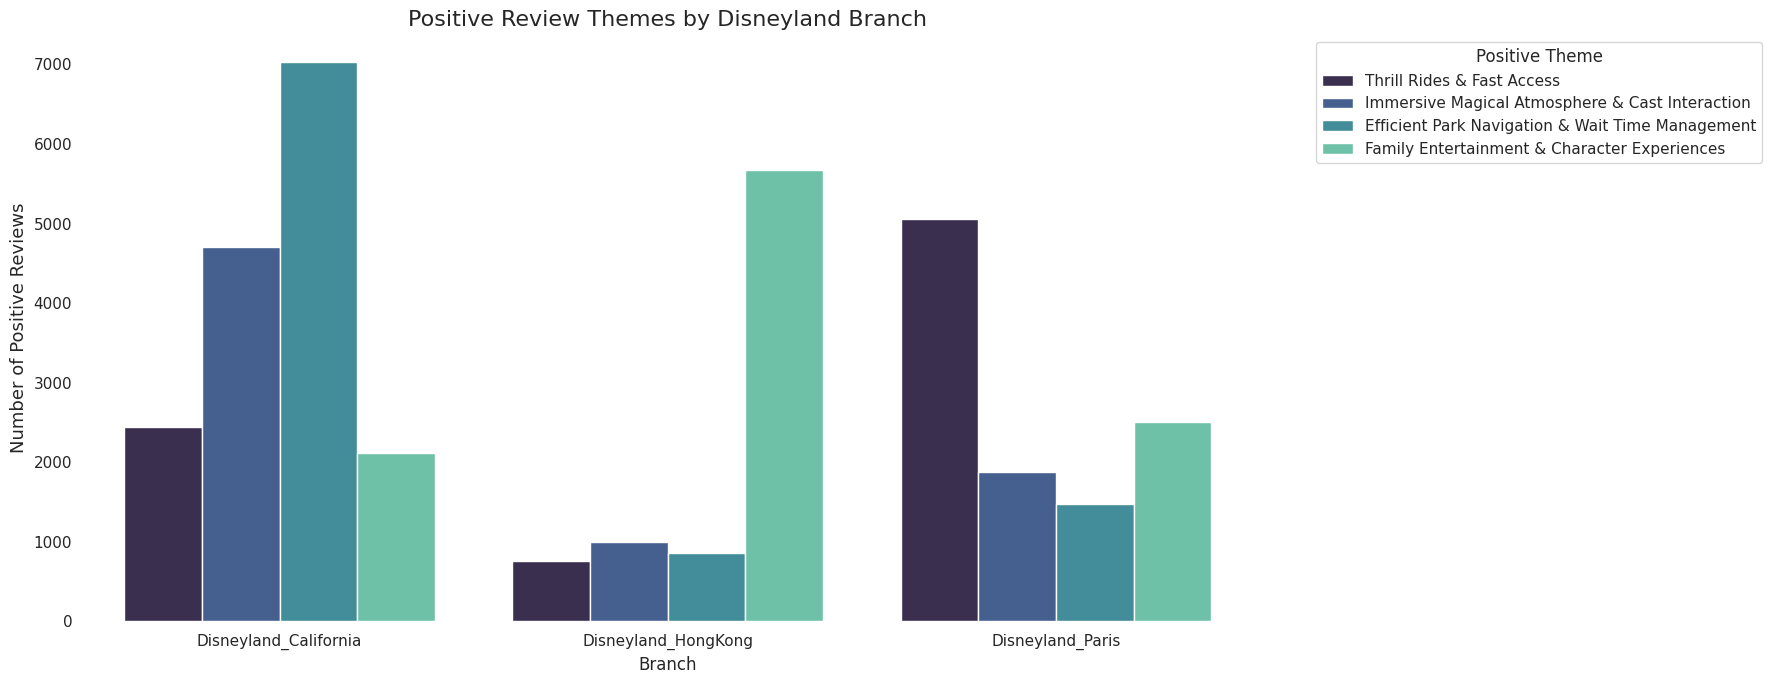

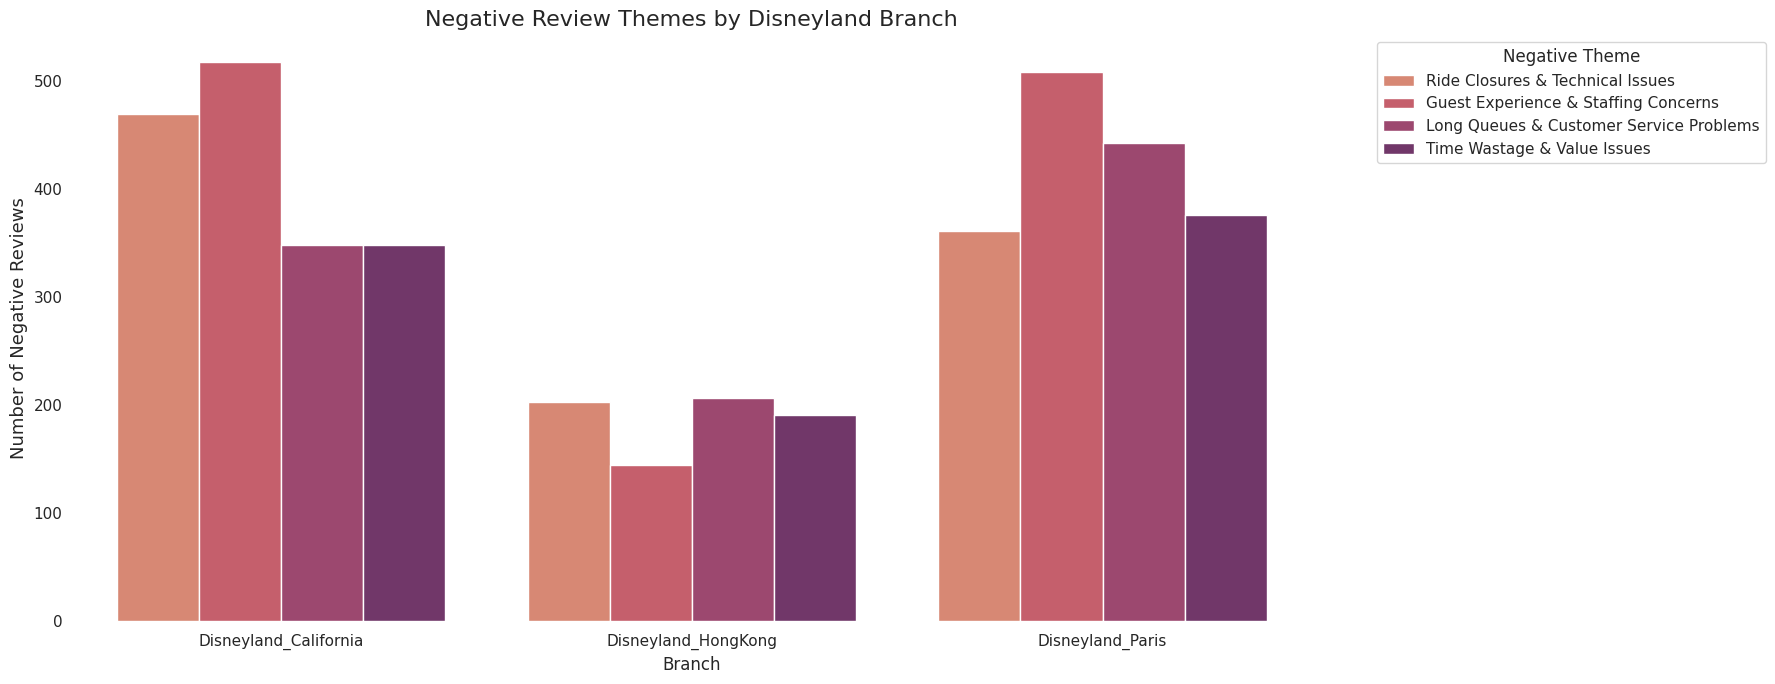

In [142]:
# Labels for themes
positive_labels = [
    "Thrill Rides & Fast Access",
    "Immersive Magical Atmosphere & Cast Interaction",
    "Efficient Park Navigation & Wait Time Management",
    "Family Entertainment & Character Experiences"
]

negative_labels = [
    "Ride Closures & Technical Issues",
    "Guest Experience & Staffing Concerns",
    "Long Queues & Customer Service Problems",
    "Time Wastage & Value Issues"
]

# Aggregate counts by branch and dominant topic
pos_summary = positive_reviews.groupby(['Branch', 'Dominant_Topic_Pos']).size().reset_index(name='Count')
pos_summary['Theme'] = pos_summary['Dominant_Topic_Pos'].apply(lambda x: positive_labels[int(x)])
pos_summary['Sentiment'] = 'Positive'

neg_summary = negative_reviews.groupby(['Branch', 'Dominant_Topic_Neg']).size().reset_index(name='Count')
neg_summary['Theme'] = neg_summary['Dominant_Topic_Neg'].apply(lambda x: negative_labels[int(x)])
neg_summary['Sentiment'] = 'Negative'

# Combine positive and negative summaries for visualization
summary_df = pd.concat([
    pos_summary.rename(columns={'Dominant_Topic_Pos': 'Topic'}),
    neg_summary.rename(columns={'Dominant_Topic_Neg': 'Topic'})
], ignore_index=True)

# Separate summary for positive and negative
positive_summary_df = summary_df[summary_df['Sentiment'] == 'Positive']
negative_summary_df = summary_df[summary_df['Sentiment'] == 'Negative']

# Plot for Positive Themes
plt.figure(figsize=(18, 7))
sns.barplot(data=positive_summary_df, x='Branch', y='Count', hue='Theme', palette='mako')
plt.title('Positive Review Themes by Disneyland Branch',  fontsize=16)
plt.ylabel('Number of Positive Reviews', fontsize = 13)
plt.xticks()
plt.grid(False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.legend(title='Positive Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Force extra blank space between plots
print("\n" * 2)

# Plot for Negative Themes
plt.figure(figsize=(18, 7))
sns.barplot(data=negative_summary_df, x='Branch', y='Count', hue='Theme', palette='flare')
plt.title('Negative Review Themes by Disneyland Branch',  fontsize=16)
plt.ylabel('Number of Negative Reviews', fontsize = 13)
plt.xticks()
plt.grid(False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.legend(title='Negative Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 8. Dashboard

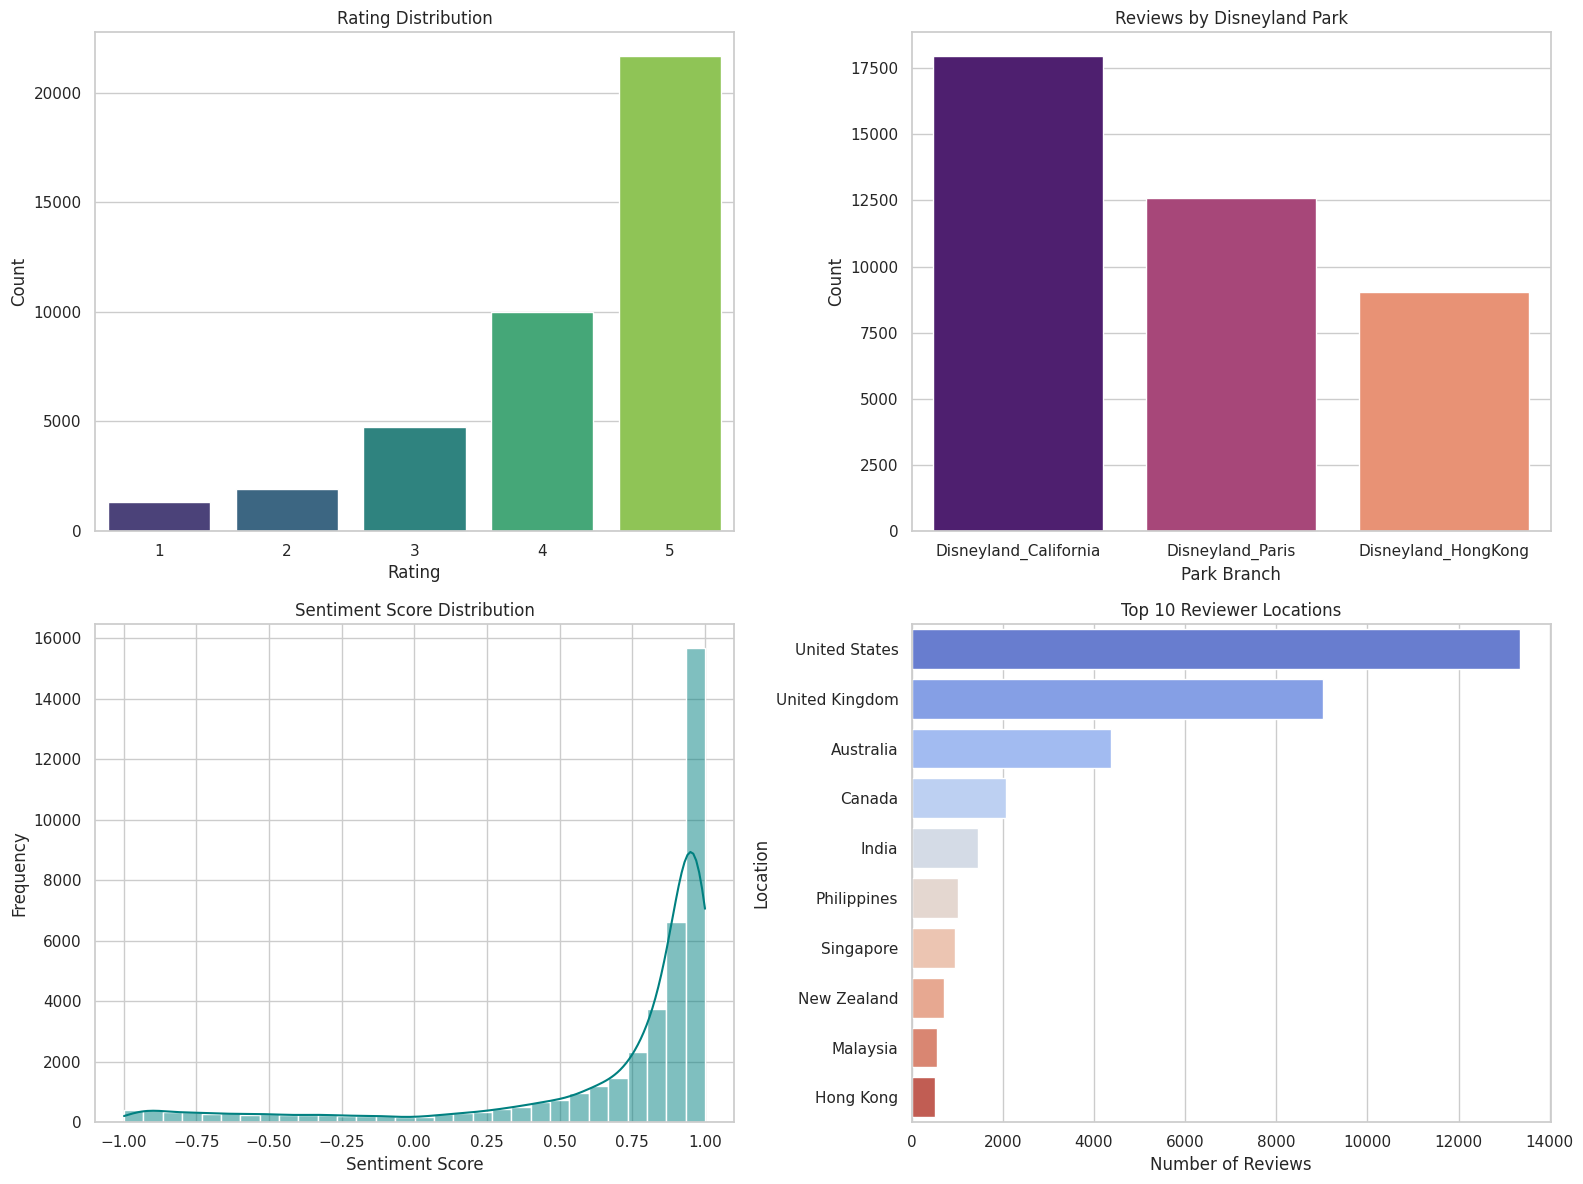

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set(style='whitegrid')
plt.figure(figsize=(16, 12))

# Subplot 1: Rating Distribution
plt.subplot(2, 2, 1)
sns.countplot(x='Rating', data=disney_df, palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

# Subplot 2: Reviews by Park
plt.subplot(2, 2, 2)
sns.countplot(x='Branch', data=disney_df, palette='magma', order=disney_df['Branch'].value_counts().index)
plt.title('Reviews by Disneyland Park')
plt.xlabel('Park Branch')
plt.ylabel('Count')

# Subplot 3: Sentiment Score (VADER or your own score)
plt.subplot(2, 2, 3)
sns.histplot(disney_df['Sentiment_Score'], bins=30, kde=True, color='teal')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Subplot 4: Top 10 Reviewer Locations
plt.subplot(2, 2, 4)
top_locs = disney_df['Reviewer_Location'].value_counts().head(10)
sns.barplot(y=top_locs.index, x=top_locs.values, palette='coolwarm')
plt.title('Top 10 Reviewer Locations')
plt.xlabel('Number of Reviews')
plt.ylabel('Location')

plt.tight_layout()
plt.show()


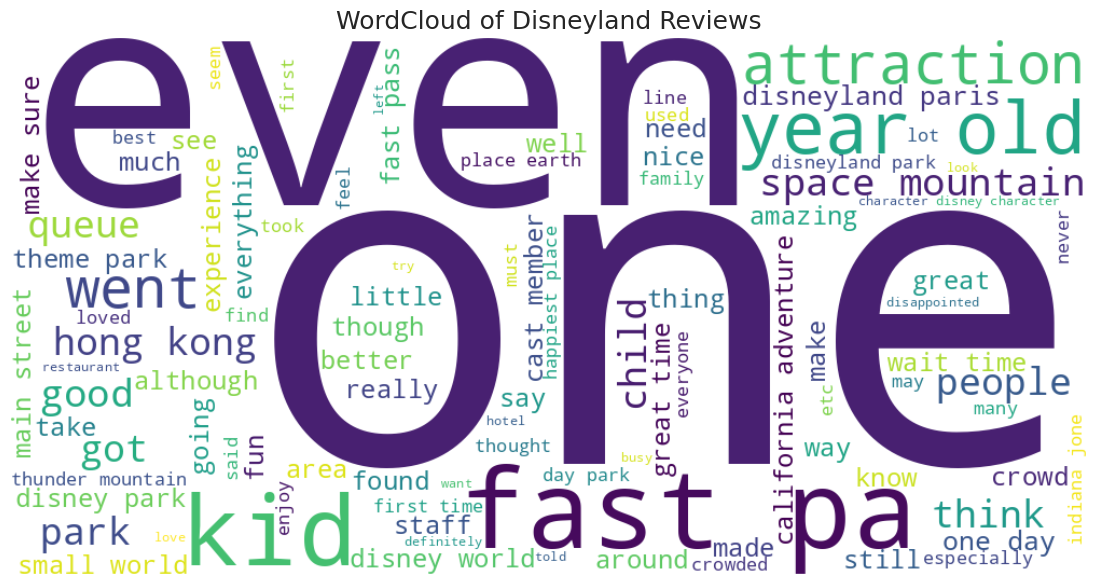

In [144]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all cleaned text into one big string
text = ' '.join(disney_df['Clean_Text'].dropna().astype(str))

# Generate WordCloud
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='white',
    colormap='viridis',
    max_words=100,
    random_state=42
).generate(text)

# Plot it
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Disneyland Reviews', fontsize=18)
plt.show()
